GC Net Data

In [2]:
!pip install pyarrow

You should consider upgrading via the '/Users/nilsfulde/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
!pip install git+https://github.com/GEUS-PROMICE/pyNEAD.git

  Cloning https://github.com/GEUS-PROMICE/pyNEAD.git to c:\users\mabj16ac\appdata\local\temp\4\pip-req-build-1zu17gro
  Resolved https://github.com/GEUS-PROMICE/pyNEAD.git to commit d811220c2d048d84d4612b045880d6ca914c39a4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nead: filename=nead-0.0.0-py2.py3-none-any.whl size=10663 sha256=4736ab4fc8e3fe62dc67c2c15b6c58ff60aed7a9afae1d2942330122de5b691b
  Stored in directory: C:\Users\mabj16ac\AppData\Local\Temp\4\pip-ephem-wheel-cache-zymeu2hk\wheels\7e\b5\9c\bf1fb23ef32c0fd131d467e2ee10e1bc483361a4dba16b3600
Successfully built nead


  Running command git clone --filter=blob:none --quiet https://github.com/GEUS-PROMICE/pyNEAD.git 'C:\Users\mabj16ac\AppData\Local\Temp\4\pip-req-build-1zu17gro'


In [19]:
import os
print(os.getcwd())
os.chdir('c:\\Users\\mabj16ac\\Desktop\\Thesis\\GEUS-Master-Thesis\\scripts')
os.chdir("../")

c:\Users\mabj16ac\Desktop\Thesis\GEUS-Master-Thesis\scripts


In [20]:
#!/usr/bin/env bash

# Latest L1 data: https://github.com/GEUS-Glaciology-and-Climate/GC-Net-level-1-data-processing/tree/main/L1
# API contents of latest L1 data (raw URLs etc.): https://api.github.com/repositories/319306521/contents/L1

import os
os.getcwd()
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
os.chdir('c:\\Users\\mabj16ac\\Desktop\\Thesis\\GEUS-Master-Thesis\\scripts')
os.chdir("../")
print(os.getcwd())


try:
    os.mkdir("data")
    os.mkdir("data/gc_net/raw_data/data_daily")
    os.mkdir("data/gc_net/raw_data/data_hourly")
except:
    print('Overwritting existing data in "/data"')

import urllib.request

# Download data
print("Downloading daily data...\r")


# xargs -n 1 curl --silent -O --output-dir data_daily < ../metadata/urls_1.txt
for url in open("metadata/urls_1.txt"):
    # Split on the rightmost / and take everything on the right side of that
    name = url.rsplit("/", 1)[-1].replace("\r", "")
    # Strip /n at the end of filename
    name = name.strip()
    # Combine the name and the downloads directory to get the local filename
    filename = os.path.join("data/gc_net/raw_data/data_daily", name)

    # Download the file if it does not exist
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)


c:\Users\mabj16ac\Desktop\Thesis\GEUS-Master-Thesis
Overwritting existing data in "/data"


In [21]:
print("Downloading hourly data...\r")
# xargs -n 1 curl --silent -O --output-dir data_hourly < ../metadata/urls_2.txt
for url in open("metadata/urls_2.txt"):
    # Split on the rightmost / and take everything on the right side of that
    name = url.rsplit("/", 1)[-1].replace("\r", "")
    # Strip /n at the end of filename
    name = name.strip()
    # Combine the name and the downloads directory to get the local filename
    filename = os.path.join("data/gc_net/raw_data/data_hourly", name)

    # Download the file if it does not exist
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)

In [65]:
import pandas as pd
import nead

def process_gcnet_daily():
    print('PROCESSING GC_NET DAILY...')
    # Convert NEAD files to Pandas dataframes
    station = pd.read_csv("metadata/station_info.csv", header=0)
    dfs_daily = []

    for name, ID in zip(station.Name, station.ID):
        format_name = name.replace(" ", "")
        files = "data/gc_net/raw_data/data_daily/" + str(ID).zfill(2) + "-" + format_name + "_daily.csv"
        ds_daily = nead.read(files, index_col=0)
        df_daily = ds_daily.to_dataframe()
        df_daily.insert(
            loc=0, column="station_name", value=name
        )  # Add station_name column to each dataframe
        dfs_daily.append(df_daily)

    # Concatenate dataframes
    df_daily = pd.concat(dfs_daily).sort_index()

    # Delete irrelevant columns from dataframe (i.e. null columns and flag columns)
    # null_columns = df_daily.columns[df_daily.isnull().all()]
    # flag_columns = df_daily.filter(regex="flag$").columns
    # print(null_columns)
    # print(flag_columns)

    df_daily = df_daily.drop(
        columns=[
            "OSWR_max",
            "HW2_adj_flag",
            "P_adj_flag",
            "HW1_adj_flag",
            "OSWR_adj_flag",
            "HS1_adj_flag",
            "HS2_adj_flag",
            "TA3_adj_flag",
            "TA4_adj_flag",
            "DW1_adj_flag",
        ]
    )
    # Add season column to dataframe
    seasons = {
        1: "Winter",
        2: "Winter",
        3: "Spring",
        4: "Spring",
        5: "Spring",
        6: "Summer",
        7: "Summer",
        8: "Summer",
        9: "Autumn",
        10: "Autumn",
        11: "Autumn",
        12: "Winter",
    }

    # Extract the month from the index and use the dictionary to map it to the corresponding season
    df_daily["season"] = df_daily.index.month.map(seasons)

    # Add year column to dataframe
    df_daily["year"] = df_daily.index.strftime("%Y")

    # Add month column to dataframe
    df_daily["month"] = df_daily.index.strftime("%B")

    # Rename Index Column to Datetime
    df_daily = df_daily.reset_index(inplace=False)
    df_daily = df_daily.rename(columns={'timestamp': 'Datetime'}, inplace=False) 

    # Rename 'station_name' to file
    df_daily = df_daily.rename(columns={'station_name': 'file'}, inplace=False)

    # Add Day of Year & Day of Century 
    df_daily['DayOfYear'] = df_daily['Datetime'].dt.dayofyear 
    df_daily['DayOfCentury'] = df_daily['Datetime'].dt.dayofyear+365*(df_daily['Datetime'].dt.year-1)


    # # Add day column to dataframe
    # df_daily["day"] = df_daily.index.strftime("%d")

    # Add hour column to dataframe
    # df_daily["hour"] = df_daily.index.strftime("%h")

    # Change column headers
    #header = pd.read_csv('/content/drive/MyDrive/Master_Thesis/metadata/Masterdata_GCNET.csv', sep = ";")
    header = pd.read_csv('metadata/Masterdata_GCNET.csv', sep = ";")
    df_daily = df_daily.rename(columns = header.set_index('fields')['display_description'])

    print('SAVING PROCESSED GC_NET_DAILY TO CSVs...')
    counter = 1
    for station in df_daily['file'].unique():
        station_csv = df_daily.loc[df_daily['file'] == station]
        station_csv.to_csv('data/gc_net/daily_data/{num}_{station}.csv'.format(num=counter,station=station))
        counter += 1 
    print('FINISHED SAVING GC_NET DAILY TO CSVs')
    return df_daily

def process_gcnet_hourly():
    print('PROCESSING GC_NET HOURLY...')
    station = pd.read_csv("metadata/station_info.csv", header=0)
    dfs_hourly = []

    for name, ID in zip(station.Name, station.ID):
        format_name = name.replace(" ", "")
        files = "data/gc_net/raw_data/data_hourly/" + str(ID).zfill(2) + "-" + format_name + ".csv"
        ds_hourly = nead.read(files, index_col=0)
        df_hourly = ds_hourly.to_dataframe()
        df_hourly.insert(
            loc=0, column="station_name", value=name
        )  # Add station_name column to each dataframe
        dfs_hourly.append(df_hourly)

    # Concatenate dataframes
    df_hourly = pd.concat(dfs_hourly).sort_index()

    # Delete irrelevant columns from dataframe (i.e. null columns and flag columns)
    # null_columns = df_hourly.columns[df_hourly.isnull().all()]
    # flag_columns = df_hourly.filter(regex="flag$").columns
    # print(null_columns)
    # print(flag_columns)

    df_hourly = df_hourly.drop(
        columns=[
            "OSWR_max",
            "HW2_adj_flag",
            "P_adj_flag",
            "HW1_adj_flag",
            "OSWR_adj_flag",
            "HS1_adj_flag",
            "HS2_adj_flag",
            "TA3_adj_flag",
            "TA4_adj_flag",
            "DW1_adj_flag",
        ]
    )
    # Add year column to dataframe
    df_hourly["year"] = df_hourly.index.strftime("%Y")

    # Add month column to dataframe
    df_hourly["month"] = df_hourly.index.strftime("%B")

    # Add season column to dataframe
    seasons = {
        1: "Winter",
        2: "Winter",
        3: "Spring",
        4: "Spring",
        5: "Spring",
        6: "Summer",
        7: "Summer",
        8: "Summer",
        9: "Autumn",
        10: "Autumn",
        11: "Autumn",
        12: "Winter",
    }

    # Extract the month from the index and use the dictionary to map it to the corresponding season
    df_hourly["season"] = df_hourly.index.month.map(seasons)


    #Rename Index Column to Datetime
    df_hourly = df_hourly.reset_index(inplace=False)
    df_hourly = df_hourly.rename(columns={'timestamp': 'Datetime'}, inplace=False) 

    # Rename 'station_name' to file
    df_hourly = df_hourly.rename(columns={'station_name': 'file'}, inplace=False)

    # Add Day of Year & Day of Century 
    df_hourly['DayOfYear'] = df_hourly['Datetime'].dt.dayofyear 
    df_hourly['DayOfCentury'] = df_hourly['Datetime'].dt.dayofyear+365*(df_hourly['Datetime'].dt.year-1)


    # # Add day column to dataframe
    # df_hourly["day"] = df_hourly.index.strftime("%d")

    # # Add hour column to dataframe
    # df_hourly["hour"] = df_hourly.index.strftime("%h")


    #header = pd.read_csv('/content/drive/MyDrive/Master_Thesis/metadata/Masterdata_GCNET.csv', sep = ";")
    header = pd.read_csv('metadata/Masterdata_GCNET.csv', sep = ";")
    df_hourly = df_hourly.rename(columns = header.set_index('fields')['display_description'])

    print('SAVING PROCESSED GC_NET HOURLY TO CSVs')
    counter = 1
    for station in df_hourly['file'].unique():
        station_csv = df_hourly.loc[df_hourly['file'] == station]
        station_csv.to_csv('data/gc_net/hourly_data/{num}_{station}.csv'.format(num=counter,station=station))
        counter += 1 
    print('FINISHED SAVING GC_NET HOURLY TO CSVs')
    

    # Save dataframe as parquet file
    #df_hourly.to_parquet("data/df_hourly.gzip", compression="gzip", engine='pyarrow')
    

In [ ]:
process_gcnet_daily()
process_gcnet_hourly()


In [5]:
import pandas as pd
import os
print(os.getcwd())
df = pd.read_csv('../data/promice/new_promice/hourly_data/10_Kan_L.csv')

c:\Users\mabj16ac\Desktop\Thesis\GEUS-Master-Thesis\scripts


New Promice

In [7]:
import pandas as pd
import numpy as np
import os
from scipy.interpolate import interp1d

def process_hourly_data(csv_directory="..\..\PROMICE-AWS-toolbox\out\\test_folder", add_meta_data=False):
        # List all CSV files in the directory
    csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

    # Combine all CSV files into a single DataFrame
    dfs = []
    for f in csv_files:
        df = pd.read_csv(os.path.join(csv_directory, f))
        df.insert(0, 'stid', f[:-7])
        dfs.append(df)
    df_hourly = pd.concat(dfs)
    
    #read metadata from promice repository
    station = pd.read_csv('../../PROMICE-AWS-toolbox/metadata/AWS_station_locations.csv', index_col=False)
    station.to_csv('../data/promice/new_promice/AWS_station_locations.csv', index=False)


    #display(output station and columns summary)
    print('Stations loaded:')
    display(df_hourly['stid'].unique())
    print('columns in dataset:')
    print(list(df_hourly.columns))
    print("FINISHED LOADING CSV's")

    # Add year column to dataframe
    df_hourly["Datetime"] = pd.to_datetime(df_hourly['time'])

    #Rename Index Column to Datetime
    df_hourly = df_hourly.reset_index(inplace=False)

    if add_meta_data==True:
        add_nice_to_haves(df_hourly, 'hourly')

    header = pd.read_csv('../metadata/promice_header.csv', sep = ";")
    df_hourly = df_hourly.rename(columns = header.set_index('standard_name')['units']) #Units because headers are shifted

    df_hourly["Datetime"] = pd.to_datetime(df_hourly['date'],format = '%y-%m-%d %H:%M:%S')
    
    for i in df_hourly['stid'].unique().to_list():
        
        df_hourly['index'] = df_hourly.index
        df_hourly = df_hourly.set_index(['Datetime'])

        smoothed_PT =  df_hourly['Depth of pressure transducer in ice - corrected'].interpolate(limit=72).rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')
        smoothed_PT = smoothed_PT.rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')

        threshold_ablation = -0.0002 # Modify value if needed
        ind_ablation = np.logical_and(smoothed_PT.diff().values < threshold_ablation, 
                                    np.isin(smoothed_PT.diff().index.month, [6, 7, 8, 9]))

        ind_ablation = np.concatenate((ind_ablation[4*24:], np.repeat(ind_ablation[-(4*24):-(4*24-1)], 4*24)))

        df_hourly['Ablation'] = ind_ablation.tolist()

        df_hourly['Datetime'] = df_hourly.index
        df_hourly = df_hourly.set_index(['index'])
    
    counter = 1
    for station in df_hourly['stid'].unique():
        station_csv = df_hourly.loc[df_hourly['stid'] == station]
        station_csv.to_csv('../data/promice/new_promice/backup/{station}.csv'.format(num=counter,station=station), index=False)
        counter += 1 
    

    print("FINISHED PROCESSING HOURLY DATA")
    return df_hourly

def process_daily_data(dataframe=None, directory="../data/promice/new_promice/backup", add_meta_data=False):
    
    if not isinstance(dataframe, pd.DataFrame):
        # List all CSV files in the directory
        csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

        # Combine all CSV files into a single DataFrame
        dfs = []
        for f in csv_files:
            df = pd.read_csv(os.path.join(directory, f), index_col=0)
            dfs.append(df)
            df = pd.concat(dfs)
        print('finished loading csvs')
    else:
        df = dataframe.copy()

    # Define the date column that you want to group by (replace "date_column" with the name of your column)
    min_values_per_day = 20

    # Group the data by weather station and date
    grouped = df.groupby(['stid','date'])
    

    # Specify columns containing numerical values to be averaged
    columns_to_average = (df
                .select_dtypes(exclude=['object'])
                .drop(columns=['DayOfYear', 'DayOfCentury'])
                .columns
    )

    # Calculate the number of non-NaN values for each variable within each group
    valid_date_observations = grouped[columns_to_average].apply(lambda x: x.notna().sum() <= min_values_per_day)
    filter_excluded_columns = ['Albedo','Depth of pressure transducer in ice - corrected']
    valid_date_observations[filter_excluded_columns] = False


    # Calculate average per day per station
    df_filtered = grouped[columns_to_average].mean()

    #Remove means with less than 20 observations per day
    df_masked = df_filtered.mask(valid_date_observations, np.nan)

    df_daily = df_masked.reset_index().copy()

    df_daily["Datetime"] = pd.to_datetime(df_daily['date'],format = '%y-%m-%d %H:%M:%S')
    display(df_daily.loc[df_daily['Albedo'].notna()]['Albedo'])

    if add_meta_data==True:
        df_daily = add_nice_to_haves(df_daily, 'daily')

    counter = 1
    for station in df_daily['stid'].unique():
        station_csv = df_daily.loc[df_daily['stid'] == station]
        station_csv.to_csv('../data/promice/new_promice/daily_data/{station}.csv'.format(num=counter,station=station),index=False)
        counter += 1 

    print("FINISHED PROCESSING DAILY DATA")
    return df_daily

###########################################################################################
### Helper functions

def add_station_info(df):
    station = pd.read_csv('../data/promice/new_promice/AWS_station_locations.csv')
    station.rename(columns={'timestamp':'station_location_timestamp'})
    df.merge(station, how='left',on=['stid','stid'])
    return df

# helper functions for adding metadata like season, day, month, year, date, DayOfYear and DayOfCentury
def add_nice_to_haves(df, period):
    def add_season(df):
        seasons = {
            1: "Winter",
            2: "Winter",
            3: "Spring",
            4: "Spring",
            5: "Spring",
            6: "Summer",
            7: "Summer",
            8: "Summer",
            9: "Autumn",
            10: "Autumn",
            11: "Autumn",
            12: "Winter",
        }

        # Extract the month from the index and use the dictionary to map it to the corresponding season
        df["season"] = df['Datetime'].dt.month.map(seasons)
        return df

    def add_common(df):
        df["year"] = df['Datetime'].dt.strftime("%Y")
        df["month"] = df['Datetime'].dt.strftime("%B")
        df["date"] = df['Datetime'].dt.date
        df['DayOfYear'] = df['Datetime'].dt.dayofyear 
        df['DayOfCentury'] = df['Datetime'].dt.dayofyear+365*(df['Datetime'].dt.year-1)
        df = add_season(df)
        return df
        
    def add_day(df):
        # Add day column to dataframe
        df["day"] = df['Datetime'].dt.strftime("%d")
        return df

    def add_hour(df):
        # Add hour column to dataframe
        df["hour"] = df['Datetime'].dt.strftime("%h")
        return df

    if period == 'hourly':
        df = add_hour(
            add_day(
            add_common(df)))

    elif period == 'daily':
        df = add_day(
            add_common(df))
    elif period == 'monthly':
        df = add_common(df)
    
    return df 


In [8]:
os.chdir('c:\\Users\\mabj16ac\\Desktop\\Thesis\\GEUS-Master-Thesis\\scripts')


df_hourly = process_hourly_data(add_meta_data=True)

############################################

df_daily = process_daily_data(add_meta_data=True)

############################################
#df_monthly = process_monthly_data(dataframe=df_daily, add_meta_data=True)
#df_monthly = df_monthly.rename(columns = header.set_index('standard_name')['units'])

#df_monthly = process_monthly_data(directory='..\\Data\\new_promice\\all_promice_data_daily.parquet.gzip', add_meta_data=True)

### helper function to add station information such as # of booms, location and classification

# df_hourly = add_station_info(df_hourly)
# df_daily = add_station_info(df_daily)
# df_monthly = add_station_info(df_monthly)

Stations loaded:


array(['KAN_L', 'SCO_L'], dtype=object)

columns in dataset:
['stid', 'time', 'p_u', 't_u', 'rh_u', 'rh_u_cor', 'qh_u', 'wspd_u', 'wdir_u', 'dsr', 'dsr_cor', 'usr', 'usr_cor', 'albedo', 'dlr', 'ulr', 'cc', 't_surf', 'dlhf_u', 'dshf_u', 'z_boom_u', 'z_stake', 'z_pt', 'z_pt_cor', 'precip_u', 'precip_u_cor', 't_i_1', 't_i_2', 't_i_3', 't_i_4', 't_i_5', 't_i_6', 't_i_7', 't_i_8', 'tilt_x', 'tilt_y', 'rot', 'gps_lat', 'gps_lon', 'gps_alt', 'gps_time', 'gps_geoid', 'gps_geounit', 'gps_hdop', 'gps_numsat', 'gps_q', 'batt_v', 'batt_v_ini', 'batt_v_ss', 'fan_dc_u', 'freq_vw', 't_log', 't_rad', 'msg_lat', 'msg_lon', 'z_pt_cor_adj_flag', 'z_surf_1', 'z_surf_2', 'z_surf_2_adj_flag', 'z_pt_cor_adj', 'z_surf_1_adj', 'z_surf_2_adj', 'z_surf_combined', 'depth_t_i_1', 'depth_t_i_2', 'depth_t_i_3', 'depth_t_i_4', 'depth_t_i_5', 'depth_t_i_6', 'depth_t_i_7', 'depth_t_i_8', 't_i_10m']
FINISHED LOADING CSV's


ValueError: index values must be monotonic

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242719 entries, 0 to 242718
Data columns (total 99 columns):
 #   Column                                                              Non-Null Count   Dtype         
---  ------                                                              --------------   -----         
 0   stid                                                                242719 non-null  object        
 1   date                                                                242719 non-null  object        
 2   Air pressure (upper boom)                                           174518 non-null  float64       
 3   Air temperature (upper boom)                                        198448 non-null  float64       
 4   Relative humidity (upper boom)                                      181294 non-null  float64       
 5   Relative humidity (upper boom) - corrected                          181294 non-null  float64       
 6   Specific humidity (upper boom)              

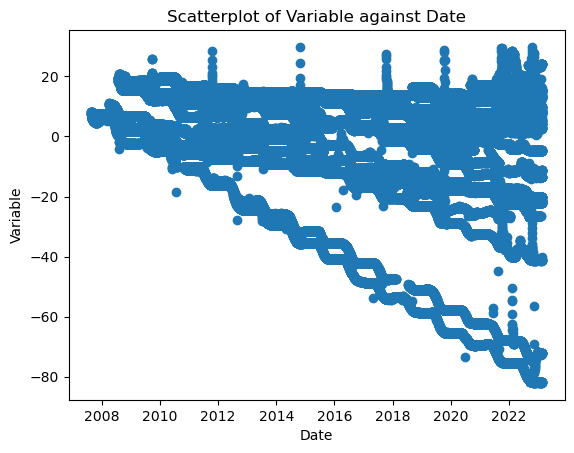

In [115]:
import matplotlib.pyplot as plt
import pandas as pd
df_daily = df_daily.loc[df_daily['stid']]
print(df_daily.info())
df_daily["Datetime"] = pd.to_datetime(df_daily['date'])
# Extract the date column and the variable column
date_col = df_daily['Datetime']
variable_col = df_daily['Depth of pressure transducer in ice - corrected']

# Create a scatterplot
plt.scatter(date_col, variable_col)

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Variable')
plt.title('Scatterplot of Variable against Date')

# Display the plot
plt.show()

In [109]:
#display(df_hourly['Albedo'].isna().sum().sum())
#df_hourly['Albedo'].describe()
#df_hourly['month_num'] = df_hourly['Datetime'].dt.month

#grouped = (df_hourly
#           .sort_values(by='month_num')
#           .groupby(['month_num'])
#           .agg({'Albedo':['count','size', 'mean']})
#)
#display(grouped)
#display(df_hourly)
#display(df_daily)
df_daily['month_num'] = df_daily['Datetime'].dt.month
df_daily_kan = df_daily.loc[df_daily['stid'] == 'KAN_L']
display(df_daily_kan['Albedo'].isna().sum().sum())
#df_hourly['Albedo'].describe()
print(df_daily_kan.info())

grouped = (df_daily_kan
           .sort_values(by='month_num')
           .groupby(['month_num'])
           .agg({'Albedo':['count','size', 'mean'],'Air temperature (upper boom)':['mean']})
)

grouped2 = (df_daily_kan
           .sort_values(by='month_num')
           .groupby(['year'])
           .agg({'Albedo':['count','size', 'mean'],'Air temperature (upper boom)':['mean']})
)

grouped3 = (df_daily
           .sort_values(by='month_num')
           .groupby(['month_num'])
           .agg({'Albedo':['count','size', 'mean'],'Air temperature (upper boom)':['mean']})
)

grouped4 = (df_daily
           .sort_values(by='month_num')
           .groupby(['year'])
           .agg({'Albedo':['count','size', 'mean'],'Air temperature (upper boom)':['mean']})
)
columns = [
'Ice temperature interpolated at 10 m depth', # excluded due to missing values
'Air pressure (lower boom)', # excluded due to missing values
'Air temperature (lower boom)', # excluded due to missing values
'Relative humidity (lower boom)', # excluded due to missing values
'Relative humidity (lower boom) - corrected', # excluded due to missing values
'Specific humidity (lower boom)', # excluded due to missing values
'Wind speed (lower boom)', # excluded due to missing values
'Wind from direction (lower boom)', # excluded due to missing values
'Latent heat flux (lower boom)', # excluded due to missing values
'Sensible heat flux (lower boom)', # excluded due to missing values
'Lower boom height', # excluded due to missing values
'Precipitation (lower boom) (cumulative solid & liquid)', # excluded due to missing values
'Precipitation (lower boom) (cumulative solid & liquid) – corrected', # excluded due to missing values
'Ice temperature at sensor 9', # excluded due to missing values
'Ice temperature at sensor 10', # excluded due to missing values
'Ice temperature at sensor 11', # excluded due to missing values
'Fan current (lower boom)', # excluded due to missing values
'Depth of ice temperature measurement 9', # excluded due to missing values
'Depth of ice temperature measurement 10', # excluded due to missing values
'Depth of ice temperature measurement 11', # excluded due to missing values
]
col_dict = dict.fromkeys(columns, ['count','size', 'mean'])


print('kan_l albedo by month')
display(grouped)
print('kan_l albedo by year')
display(grouped2)
print('all albedo by month')
display(grouped3)
print('all albedo by year')
display(grouped4)

count = [0,5,10,15,20,25,30]
idx = 0
for i in range(0,len(col_dict)):
    col_dict = dict.fromkeys(columns[count[idx]:count[idx+1]],['count','size','mean'])
    grouped5 = (df_daily
            .sort_values(by='month_num')
            .groupby(['month_num'])
            .agg(col_dict)
    )

    grouped6 = (df_daily
            .sort_values(by='month_num')
            .groupby(['year'])
            .agg(col_dict)
    )
    print('kan missing values columns')
    display(grouped5.head(20))
    print('all missing values columns')
    display(grouped6.head(30))
    idx += 1
print('kan missing values columns')
display(grouped5.head(20))
print('all missing values columns')
display(grouped6.head(30))


2475

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5286 entries, 57347 to 62632
Data columns (total 100 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   stid                                                                5286 non-null   object        
 1   date                                                                5286 non-null   object        
 2   Air pressure (upper boom)                                           5168 non-null   float64       
 3   Air temperature (upper boom)                                        5168 non-null   float64       
 4   Relative humidity (upper boom)                                      5168 non-null   float64       
 5   Relative humidity (upper boom) - corrected                          5168 non-null   float64       
 6   Specific humidity (upper boom)                    

Albedo                Air temperature (upper boom)
           count size      mean                         mean
month_num                                                   
1              0  465       NaN                   -15.294901
2              0  415       NaN                   -16.931623
3            236  434  0.708492                   -15.688888
4            411  420  0.683987                    -9.099937
5            434  434  0.663460                    -2.404802
6            420  420  0.554134                     2.486183
7            434  434  0.505758                     3.737849
8            434  434  0.531993                     2.863395
9            442  450  0.727276                    -1.760853
10             0  465       NaN                    -7.074471
11             0  450       NaN                   -11.633425
12             0  465       NaN                   -13.300805

kan_l albedo by year


Albedo                Air temperature (upper boom)
      count size      mean                         mean
year                                                   
2008     28  122  0.786306                    -9.530245
2009    200  365  0.623194                    -7.452063
2010    201  365  0.587677                    -3.497304
2011    201  365  0.589572                    -8.611602
2012    201  366  0.604735                    -6.485886
2013    201  365  0.641850                    -7.355029
2014    201  365  0.619530                    -7.544973
2015    201  365  0.675456                   -10.228733
2016    201  366  0.616692                    -5.702000
2017    200  365  0.615595                    -6.804629
2018    201  365  0.613605                    -8.031608
2019    201  365  0.583308                    -5.365419
2020    200  366  0.617154                    -7.213031
2021    201  365  0.636699                    -6.103182
2022    173  365  0.622203                    -5.444956
2023      0   51       NaN                          NaN

all albedo by month


Albedo                  Air temperature (upper boom)
           count   size      mean                         mean
month_num                                                     
1              0  21348       NaN                   -22.576378
2             67  19003  0.612505                   -23.365323
3           5371  20115  0.793937                   -22.564493
4          13174  19597  0.785905                   -16.011109
5          16493  20538  0.770876                    -9.339904
6          17107  20188  0.709365                    -3.169284
7          17890  21034  0.642545                    -1.097650
8          17755  21324  0.639144                    -2.891613
9          10707  20981  0.689008                    -8.967346
10          1082  21603  0.663477                   -14.950173
11             0  20873       NaN                   -19.850672
12             0  21447       NaN                   -21.508552

all albedo by year


Albedo                  Air temperature (upper boom)
      count   size      mean                         mean
year                                                     
1990     61    214  0.854642                          NaN
1991      0    365       NaN                          NaN
1992      0    366       NaN                          NaN
1993    100    365  0.781537                          NaN
1994    187    365  0.848593                          NaN
1995    578   1204  0.768898                   -14.153692
1996   1123   2478  0.796147                   -17.056158
1997   1748   3672  0.790962                   -18.250423
1998   1829   4267  0.790778                   -19.302913
1999   1989   4380  0.795666                   -20.488128
2000   2108   4392  0.799718                   -20.079642
2001   1984   4380  0.807421                   -19.621109
2002   1557   4380  0.795661                   -20.655867
2003   1674   4380  0.800255                   -17.898381
2004   1488   4392  0.820199                   -20.146343
2005   1806   4380  0.826615                   -19.221261
2006   2078   4658  0.834715                   -20.455881
2007   1980   5274  0.804134                   -18.433890
2008   2594   7972  0.699184                   -12.743097
2009   3703  10370  0.689304                   -11.350282
2010   3882  11255  0.691265                   -10.218864
2011   4376  12142  0.667546                   -12.303436
2012   4948  12578  0.651579                   -10.703674
2013   5225  12775  0.700320                   -12.400103
2014   5827  12773  0.689322                   -11.925874
2015   5143  12647  0.703768                   -13.893647
2016   5897  12832  0.673754                   -10.733978
2017   5697  13363  0.695198                   -12.133555
2018   5976  13729  0.724785                   -13.381985
2019   5811  13771  0.661538                   -11.238047
2020   5361  13886  0.682646                   -12.537298
2021   6082  15058  0.668501                   -10.425833
2022   6818  17021  0.612218                    -8.101665
2023     16   1967  0.124073                   -20.421718

kan missing values columns


Ice temperature interpolated at 10 m depth                    \
                                               count   size       mean   
month_num                                                                
1                                               6176  21348 -15.015771   
2                                               5417  19003 -15.196786   
3                                               6081  20115 -15.110471   
4                                               6113  19597 -15.351987   
5                                               6508  20538 -14.952365   
6                                               5904  20188 -15.903178   
7                                               5346  21034 -18.205699   
8                                               5559  21324 -17.683879   
9                                               6101  20981 -15.765862   
10                                              6312  21603 -15.635039   
11                                              6164  20873 -15.528199   
12                                              6230  21447 -15.277711   

          Air pressure (lower boom)                     \
                              count   size        mean   
month_num                                                
1                               288  21348  768.584328   
2                               147  19003  764.476627   
3                                93  20115  716.380565   
4                               120  19597  737.503936   
5                               141  20538  765.312112   
6                               302  20188  784.279409   
7                               490  21034  781.065165   
8                               504  21324  776.987048   
9                               508  20981  775.664152   
10                              507  21603  771.582208   
11                              465  20873  767.948194   
12                              396  21447  774.575499   

          Air temperature (lower boom)                    \
                                 count   size       mean   
month_num                                                  
1                                 5940  21348 -32.036398   
2                                 5003  19003 -32.777465   
3                                 5502  20115 -31.377004   
4                                 6097  19597 -24.219534   
5                                 7017  20538 -16.518041   
6                                 7405  20188  -8.867273   
7                                 7731  21034  -6.514047   
8                                 7608  21324  -9.368117   
9                                 7311  20981 -17.317090   
10                                7360  21603 -24.323664   
11                                6819  20873 -28.852819   
12                                6402  21447 -30.944766   

          Relative humidity (lower boom)                    \
                                   count   size       mean   
month_num                                                    
1                                   5627  21348  72.673036   
2                                   4588  19003  72.078022   
3                                   5063  20115  72.926016   
4                                   5554  19597  77.670875   
5                                   6499  20538  79.560761   
6                                   6992  20188  83.221096   
7                                   7339  21034  85.622103   
8                                   7224  21324  86.431980   
9                                   6980  20981  83.486547   
10                                  6947  21603  79.085206   
11                                  6435  20873  75.472027   
12                                  6048  21447  73.590654   

          Relative humidity (lower boom) - corrected                    
                                               count   size       mean  
month_num                                         

all missing values columns


Ice temperature interpolated at 10 m depth                    \
                                          count   size       mean   
year                                                                
1990                                          0    214        NaN   
1991                                          0    365        NaN   
1992                                          0    366        NaN   
1993                                          0    365        NaN   
1994                                          0    365        NaN   
1995                                        216   1204 -19.170430   
1996                                        906   2478 -19.126445   
1997                                       1993   3672 -20.740846   
1998                                       2194   4267 -22.170764   
1999                                       2467   4380 -21.947684   
2000                                       2756   4392 -21.026309   
2001                                       2781   4380 -20.701191   
2002                                       2725   4380 -21.211653   
2003                                       2399   4380 -22.177102   
2004                                       2757   4392 -21.638445   
2005                                       2575   4380 -22.312818   
2006                                       2643   4658 -22.229382   
2007                                       2366   5274 -23.033279   
2008                                       2783   7972 -18.095504   
2009                                       2752  10370 -14.807418   
2010                                       1893  11255 -16.241838   
2011                                       2036  12142 -11.597254   
2012                                       2692  12578  -9.450170   
2013                                       3069  12775  -9.049954   
2014                                       1933  12773 -11.479930   
2015                                       3069  12647  -8.412228   
2016                                       2939  12832  -8.931511   
2017                                       3056  13363 -10.178318   
2018                                       3826  13729 -11.172295   
2019                                       2827  13771  -9.873980   

     Air pressure (lower boom)             Air temperature (lower boom)  \
                         count   size mean                        count   
year                                                                      
1990                         0    214  NaN                            0   
1991                         0    365  NaN                            0   
1992                         0    366  NaN                            0   
1993                         0    365  NaN                            0   
1994                         0    365  NaN                            0   
1995                         0   1204  NaN                          794   
1996                         0   2478  NaN                         1580   
1997                         0   3672  NaN                         2543   
1998                         0   4267  NaN                         3013   
1999                         0   4380  NaN                         3311   
2000                         0   4392  NaN                         3505   
2001                         0   4380  NaN                         3357   
2002                         0   4380  NaN                         2516   
2003                         0   4380  NaN                         2635   
2004                         0   4392  NaN                         2735   
2005                         0   4380  NaN                         3263   
2006                         0   4658  NaN                         3268   
2007                         0   5274  NaN                         3011   
2008                         0   7972  NaN                         2391   
2009                         0  10370  NaN                         1950   
20

kan missing values columns


Specific humidity (lower boom)                   \
                                   count   size      mean   
month_num                                                   
1                                   3914  21348  0.414368   
2                                   3218  19003  0.411464   
3                                   3463  20115  0.435721   
4                                   3922  19597  0.770021   
5                                   4700  20538  1.314680   
6                                   4984  20188  2.296395   
7                                   5300  21034  2.776251   
8                                   5160  21324  2.340863   
9                                   4993  20981  1.342505   
10                                  5041  21603  0.818307   
11                                  4661  20873  0.569591   
12                                  4247  21447  0.468504   

          Wind speed (lower boom)                   \
                            count   size      mean   
month_num                                            
1                            4728  21348  6.663887   
2                            3904  19003  6.624716   
3                            4139  20115  6.225498   
4                            5123  19597  6.142635   
5                            6446  20538  5.397367   
6                            7025  20188  5.226065   
7                            7364  21034  4.964849   
8                            7172  21324  5.091720   
9                            6876  20981  5.602545   
10                           6692  21603  5.759385   
11                           5913  20873  6.244796   
12                           5082  21447  6.338721   

          Wind from direction (lower boom)                     \
                                     count   size        mean   
month_num                                                       
1                                     3869  21348  176.967993   
2                                     3053  19003  179.654465   
3                                     3232  20115  185.821197   
4                                     4333  19597  186.962126   
5                                     5608  20538  187.738232   
6                                     6225  20188  188.363416   
7                                     6546  21034  187.830175   
8                                     6389  21324  189.936689   
9                                     6116  20981  185.725666   
10                                    5950  21603  183.590119   
11                                    5187  20873  181.870312   
12                                    4346  21447  177.335398   

          Latent heat flux (lower boom)                   \
                                  count   size      mean   
month_num                                                  
1                                   212  21348  1.572386   
2                                   122  19003  2.214462   
3                                    39  20115  0.736435   
4                                   116  19597 -0.430881   
5                                   105  20538 -2.770352   
6                                   230  20188 -5.427278   
7                                   427  21034 -4.085770   
8                                   459  21324 -0.533195   
9                                   439  20981  2.713075   
10                                  444  21603  2.587471   
11                                  394  20873  2.339390   
12                                  352  21447  2.361083   

          Sensible heat flux (lower boom)                    
                                    count   size       mean  
month_num                                                    
1                                     212  21348   7.481757  
2                                     122  19003  10.517586  
3                                      39  20115   4.093111  
4                                 

all missing values columns


Specific humidity (lower boom)                  Wind speed (lower boom)  \
                              count   size      mean                   count   
year                                                                           
1990                              0    214       NaN                       0   
1991                              0    365       NaN                       0   
1992                              0    366       NaN                       0   
1993                              0    365       NaN                       0   
1994                              0    365       NaN                       0   
1995                            295   1204  1.566700                     762   
1996                           1089   2478  1.215929                    1614   
1997                           1849   3672  1.146318                    2442   
1998                           1898   4267  1.298273                    2853   
1999                           1631   4380  1.150647                    3174   
2000                           1393   4392  1.283242                    3232   
2001                           1321   4380  1.216838                    3157   
2002                           1889   4380  1.059775                    1972   
2003                           2185   4380  1.278476                    1907   
2004                           2125   4392  1.090120                    2515   
2005                           2408   4380  1.109531                    3099   
2006                           2275   4658  1.020956                    3370   
2007                           2288   5274  1.153208                    2872   
2008                           1567   7972  1.007129                    2066   
2009                            906  10370  0.827503                    1743   
2010                           1830  11255  1.436448                    3137   
2011                           1371  12142  1.103754                    2942   
2012                            900  12578  1.739624                    2811   
2013                           1656  12775  1.256262                    2607   
2014                           2390  12773  1.303287                    2611   
2015                           2629  12647  1.124747                    2566   
2016                           2842  12832  1.406760                    2677   
2017                           2325  13363  1.237148                    2293   
2018                           2345  13729  1.257418                    2379   
2019                           2604  13771  1.428221                    2110   

                      Wind from direction (lower boom)                     \
       size      mean                            count   size        mean   
year                                                                        
1990    214       NaN                                0    214         NaN   
1991    365       NaN                                0    365         NaN   
1992    366       NaN                                0    366         NaN   
1993    365       NaN                                0    365         NaN   
1994    365       NaN                                0    365         NaN   
1995   1204  5.857685                              181   1204  142.082170   
1996   2478  5.893401                             1054   2478  182.398755   
1997   3672  5.775544                             2105   3672  186.519285   
1998   4267  5.536007                             2552   4267  188.243226   
1999   4380  5.517551                             2271   4380  187.799610   
2000   4392  5.602284                             2109   4392  187.688563   
2001   4380  5.710913                             2019   4380  187.836339   
2002   4380  5.818981                             1762   4380  190.446419   
2003   4380  6.165721                             1624   4380  184.349792   
2004   4392  6.133251                             2179 

kan missing values columns


Lower boom height                   \
                      count   size      mean   
month_num                                      
1                      5113  21348  2.250019   
2                      4341  19003  2.179897   
3                      5037  20115  2.157550   
4                      5446  19597  2.142433   
5                      6274  20538  2.467378   
6                      6881  20188  2.665580   
7                      7157  21034  2.656620   
8                      6996  21324  2.659925   
9                      6760  20981  2.570202   
10                     6560  21603  2.519921   
11                     6057  20873  2.431894   
12                     5601  21447  2.342774   

          Precipitation (lower boom) (cumulative solid & liquid)         \
                                                           count   size   
month_num                                                                 
1                                                        259      21348   
2                                                        123      19003   
3                                                         40      20115   
4                                                        116      19597   
5                                                        141      20538   
6                                                        295      20188   
7                                                        492      21034   
8                                                        501      21324   
9                                                        486      20981   
10                                                       487      21603   
11                                                       408      20873   
12                                                       359      21447   

                        \
                  mean   
month_num                
1           890.856022   
2          1597.055959   
3          2462.851109   
4          2417.222797   
5          2203.785100   
6          1044.902539   
7           636.318879   
8           634.230969   
9           588.880631   
10          679.555732   
11          502.278868   
12          613.168943   

          Precipitation (lower boom) (cumulative solid & liquid) – corrected  \
                                                                       count   
month_num                                                                      
1                                                        275                   
2                                                        167                   
3                                                        104                   
4                                                        148                   
5                                                        167                   
6                                                        297                   
7                                                        492                   
8                                                        503                   
9                                                        498                   
10                                                       503                   
11                                                       428                   
12                                                       364                   

                              Ice temperature at sensor 9                    \
            size         mean                       count   size       mean   
month_num                                                                     
1          21348   909.476324                        2600  21348 -22.331731   
2          19003  1291.435070                        2307  19003 -22.985541   
3          20115  1319.919517                        2535  20115 -23.599074   
4          19597  2062.986441                        2518  19597 -23.855846   
5          20538  

all missing values columns


Lower boom height                   \
                 count   size      mean   
year                                      
1990                 0    214       NaN   
1991                 0    365       NaN   
1992                 0    366       NaN   
1993                 0    365       NaN   
1994                 0    365       NaN   
1995               830   1204  2.146590   
1996              1700   2478  1.542671   
1997              2519   3672  1.623946   
1998              2868   4267  1.599650   
1999              3129   4380  1.866951   
2000              3142   4392  1.597333   
2001              3216   4380  1.496193   
2002              2041   4380  1.691158   
2003              1908   4380  3.902771   
2004              2605   4392  3.765750   
2005              3035   4380  3.018417   
2006              3070   4658  2.752026   
2007              2766   5274  2.602286   
2008              1982   7972  2.382171   
2009              1989  10370  2.455821   
2010              2872  11255  3.012570   
2011              2927  12142  3.486204   
2012              2888  12578  3.317153   
2013              2828  12775  2.858371   
2014              3390  12773  2.688134   
2015              3230  12647  2.600168   
2016              2866  12832  2.609153   
2017              2574  13363  2.429998   
2018              2377  13729  2.573706   
2019              2563  13771  2.333433   

     Precipitation (lower boom) (cumulative solid & liquid)              \
                                                      count   size mean   
year                                                                      
1990                                                  0        214  NaN   
1991                                                  0        365  NaN   
1992                                                  0        366  NaN   
1993                                                  0        365  NaN   
1994                                                  0        365  NaN   
1995                                                  0       1204  NaN   
1996                                                  0       2478  NaN   
1997                                                  0       3672  NaN   
1998                                                  0       4267  NaN   
1999                                                  0       4380  NaN   
2000                                                  0       4392  NaN   
2001                                                  0       4380  NaN   
2002                                                  0       4380  NaN   
2003                                                  0       4380  NaN   
2004                                                  0       4392  NaN   
2005                                                  0       4380  NaN   
2006                                                  0       4658  NaN   
2007                                                  0       5274  NaN   
2008                                                  0       7972  NaN   
2009                                                  0      10370  NaN   
2010                                                  0      11255  NaN   
2011                                                  0      12142  NaN   
2012                                                  0      12578  NaN   
2013                                                  0      12775  NaN   
2014                                                  0      12773  NaN   
2015                                                  0      12647  NaN   
2016                                                  0      12832  NaN   
2017                                                  0      13363  NaN   
2018                                                  0      13729  NaN   
2019                                                  0      13771  NaN   

     Precipitation (lower boom) (cumulative solid & liquid) – corrected  \
                                  

kan missing values columns


Ice temperature at sensor 11                    \
                                 count   size       mean   
month_num                                                  
1                                  189  21348 -17.773453   
2                                  109  19003 -17.693568   
3                                   93  20115 -19.019450   
4                                  120  19597 -19.953959   
5                                  138  20538 -18.014296   
6                                  243  20188 -19.520985   
7                                  435  21034 -20.864560   
8                                  447  21324 -20.951719   
9                                  450  20981 -21.021153   
10                                 425  21603 -20.742568   
11                                 379  20873 -20.277069   
12                                 240  21447 -18.460725   

          Fan current (lower boom)                    \
                             count   size       mean   
month_num                                              
1                              310  21348  35.026801   
2                              146  19003  30.219897   
3                               93  20115  32.463884   
4                              120  19597  41.208045   
5                              143  20538  60.765025   
6                              307  20188  68.308667   
7                              497  21034  72.268715   
8                              506  21324  68.161447   
9                              510  20981  64.213413   
10                             507  21603  57.279278   
11                             470  20873  41.631810   
12                             400  21447  36.119165   

          Depth of ice temperature measurement 9                   \
                                           count   size      mean   
month_num                                                           
1                                           7997  21348  9.407437   
2                                           7195  19003  9.482706   
3                                           7812  20115  9.562326   
4                                           7583  19597  9.551089   
5                                           7952  20538  9.389148   
6                                           7866  20188  9.094941   
7                                           8236  21034  9.034141   
8                                           8215  21324  9.062375   
9                                           7921  20981  9.125612   
10                                          8133  21603  9.153425   
11                                          7850  20873  9.243811   
12                                          8029  21447  9.340727   

          Depth of ice temperature measurement 10                   \
                                            count   size      mean   
month_num                                                            
1                                            7997  21348  9.170106   
2                                            7195  19003  9.229648   
3                                            7812  20115  9.295672   
4                                            7583  19597  9.276821   
5                                            7952  20538  9.142147   
6                                            7866  20188  8.854744   
7                                            8236  21034  8.826066   
8                                            8215  21324  8.857897   
9                                            7921  20981  8.916695   
10                                           8133  21603  8.936785   
11                                           7850  20873  9.023980   
12                                           8029  21447  9.108310   

          Depth of ice temperature measurement 11                    
                                            count   size       mean  
month_num                                

all missing values columns


Ice temperature at sensor 11             Fan current (lower boom)         \
                            count   size mean                    count   size   
year                                                                            
1990                            0    214  NaN                        0    214   
1991                            0    365  NaN                        0    365   
1992                            0    366  NaN                        0    366   
1993                            0    365  NaN                        0    365   
1994                            0    365  NaN                        0    365   
1995                            0   1204  NaN                        0   1204   
1996                            0   2478  NaN                        0   2478   
1997                            0   3672  NaN                        0   3672   
1998                            0   4267  NaN                        0   4267   
1999                            0   4380  NaN                        0   4380   
2000                            0   4392  NaN                        0   4392   
2001                            0   4380  NaN                        0   4380   
2002                            0   4380  NaN                        0   4380   
2003                            0   4380  NaN                        0   4380   
2004                            0   4392  NaN                        0   4392   
2005                            0   4380  NaN                        0   4380   
2006                            0   4658  NaN                        0   4658   
2007                            0   5274  NaN                        0   5274   
2008                            0   7972  NaN                        0   7972   
2009                            0  10370  NaN                        0  10370   
2010                            0  11255  NaN                        0  11255   
2011                            0  12142  NaN                        0  12142   
2012                            0  12578  NaN                        0  12578   
2013                            0  12775  NaN                        0  12775   
2014                            0  12773  NaN                        0  12773   
2015                            0  12647  NaN                        0  12647   
2016                            0  12832  NaN                        0  12832   
2017                            0  13363  NaN                        0  13363   
2018                            0  13729  NaN                        0  13729   
2019                            0  13771  NaN                        0  13771   

          Depth of ice temperature measurement 9                    \
     mean                                  count   size       mean   
year                                                                 
1990  NaN                                      0    214        NaN   
1991  NaN                                      0    365        NaN   
1992  NaN                                      0    366        NaN   
1993  NaN                                      0    365        NaN   
1994  NaN                                      0    365        NaN   
1995  NaN                                    837   1204   5.125044   
1996  NaN                                   1914   2478   5.939895   
1997  NaN                                   2939   3672   6.201856   
1998  NaN                                   3536   4267   5.912787   
1999  NaN                                   3650   4380   6.452648   
2000  NaN                                   3660   4392   7.062601   
2001  NaN                                   3650   4380   5.923624   
2002  NaN                                   3650   4380   5.673790   
2003  NaN                                   3650   4380   5.656131   
2004  NaN                                   3660   4392   6.782775   
2005  NaN                                   3650   4380   6.696633   
2

ValueError: No objects to concatenate

In [ ]:
def promice_pull(directory='/data/promice/new_promice/daily_data'):
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    # Combine all CSV files into a single DataFrame
    dfs = []
    for f in csv_files:
        df = pd.read_csv(os.path.join(directory, f), index_col=False)
        df.insert(0, 'stid', f[:-7])
        dfs.append(df)
    df = pd.concat(dfs)
    return df

In [ ]:
null_columns = df_hourly.columns[df_hourly.isnull().all()]
flag_columns = df_hourly.filter(regex="flag$").columns
print("null columns:\n", null_columns)
print("flag_columns:\n", flag_columns)

In [ ]:
df_monthly.info

Promice Data

In [ ]:
!wget -r -e robots=off -nH --cut-dirs=3 --content-disposition "https://dataverse.geus.dk/api/datasets/:persistentId/dirindex?persistentId=doi:10.22008/FK2/8SS7EW"

In [9]:
#############################################
# Redundant

def process_monthly_data(dataframe=None, directory="", add_meta_data=False):

    if not isinstance(dataframe, pd.DataFrame):
        df = pd.read_parquet(directory)
    else:
        df = dataframe.copy()

    df['month_year'] = df['Datetime'].dt.to_period('M')
    # Define the date column that you want to group by (replace "date_column" with the name of your column)
    min_values_per_month = 24

    # Create a new column with the month and year of the date column

    # Group the data by weather station and date
    grouped = df.groupby(['stid','month_year'])

    # Specify columns containing numerical values to be averaged
    columns_to_average = (df
                .select_dtypes(exclude=['object'])
                .drop(columns=['Datetime', 'DayOfYear', 'DayOfCentury'])
                .columns
    )

    # Calculate the number of non-NaN values for each variable within each group
    valid_date_observations = grouped[columns_to_average].apply(lambda x: x.notna().sum() <= min_values_per_month)

    # Calculate average per day per station
    df_filtered = grouped[columns_to_average].mean()

    #Remove means with less than 20 observations per day
    df_masked = df_filtered.mask(valid_date_observations, np.nan)

    df_monthly = df_masked.reset_index().copy()

    df_monthly["Datetime"] = pd.to_datetime(df_monthly['month_year'].astype(str) + '-01')

    if add_meta_data==True:
        df_monthly = add_nice_to_haves(df_monthly, 'monthly')

    #display(df_monthly)

    # Convert the DataFrame to a compressed Parquet file
    output_file = "..\\Data\\new_promice\\all_promice_data_monthly.parquet.gzip"
    df_monthly.to_parquet(output_file, compression='gzip', engine='pyarrow')

    print('FINISHED PROCESSING MONTHLY DATA')
    return df_monthly

In [10]:
# save daily data 
# Get the files from the path provided in the OP
files = Path(path).glob('*_day_v03.txt')  # .rglob to get subdirectories

dfs = list()
for f in files:
    data = pd.read_csv(f, delimiter=r"\s+", engine='python')
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

df = df.replace(-999, np.nan)

df["Month"] = df["MonthOfYear"]
df["Day"] = df["DayOfMonth"]

df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day"]], format='%Y%m%d')

# Save dataframe as parquet file
df.to_parquet("data/promice_daily.gzip", compression="gzip", engine='pyarrow')
#df.to_parquet("/content/drive/MyDrive/Master_Thesis/data/promice_daily.gzip", compression="gzip")

In [11]:
# save monthly data 
# Get the files from the path provided in the OP
files = Path(path).glob('*_month_v03.txt')  # .rglob to get subdirectories

dfs = list()
for f in files:
    data = pd.read_csv(f, delimiter=r"\s+", engine='python')
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

df = df.replace(-999, np.nan)

df["Month"] = df["MonthOfYear"]

df["Datetime"] = pd.to_datetime(['{}-{}-01'.format(y, m) for y, m in zip(df.Year, df.Month)])

# Save dataframe as parquet file
df.to_parquet("data/promice_monthly.gzip", compression="gzip", engine='pyarrow')
#df.to_parquet("/content/drive/MyDrive/Master_Thesis/data/promice_monthly.gzip", compression="gzip")